# Kaggle Molecular energy estimation. RUCODE 5.0
https://www.kaggle.com/competitions/molecular-energy-estimation-rucode

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split

from kaggle.api.kaggle_api_extended import KaggleApi

import ase.db
from ase.db import connect
from ase.visualize import view
import ase

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric as tg
import torch_geometric.data as tgd
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm

from tqdm.notebook import tqdm

In [37]:
database_path = os.path.join('raw', 'train.db')  # Путь к файлу базы данных
database = connect(database_path)  # Загрузка базы данных
row = database.get(8)  # Взятие первого элемента из базы. Нумерация начинается с 1
n_atoms = row.natoms  # Количество атомов в молекуле
numbers = row.numbers  # Атомные числа атомов молекулы
symbols = row.symbols  # Названия атомов молекулы
positions = row.positions  # Координаты атомов. np.array размера n_atoms x 3
energy = row.data.get('energy') # Энергия. np.array размера 1, содержащий энергию

# additional
mass = row.mass
formula = row.formula
n_atoms

44

In [54]:
','.join('  f ff\t\t\tf'.split())

'f,ff,f'

In [47]:
torch.from_numpy(positions.astype(np.float32))

tensor([[ -2.1459, -10.9959,  -0.1324],
        [ -6.0596,  -7.4755,   1.0196],
        [-10.7091, -10.2310,   1.3479],
        [ -5.2199,  -4.8879,   5.5567],
        [ -0.8796,  -1.8321,   5.8659],
        [ -0.7992,   2.1452,   2.5312],
        [  1.1496,   2.3394,  -1.7402],
        [  4.5844,  -2.2138,  -4.7827],
        [ 10.7821,  -1.2138,  -3.0969],
        [ 14.0728,  -4.7946,  -5.3978],
        [ 12.5968,  -9.7380,  -3.7959],
        [ 14.1063,  -4.4245, -10.3391],
        [  0.2207,   6.7500,  -3.5475],
        [ -2.3060,   9.2929,  -0.3818],
        [ -2.9932,   6.4200,   3.5225],
        [ -5.5196,   8.1051,   7.4460],
        [ -6.0763,   5.4230,  10.9218],
        [ -7.2305,  12.5913,   7.2480],
        [ -6.5284,  15.3647,   3.3927],
        [ -8.1619,  19.5895,   3.2520],
        [ -4.1077,  13.8103,  -0.4145],
        [ -3.2306,  16.6041,  -4.6569],
        [ -3.4272, -14.6463,   0.7204],
        [ -1.5473, -10.9685,  -4.1141],
        [  1.2963, -10.2164,   1.5041],


In [46]:
torch.from_numpy(numbers.astype(np.int64))

tensor([ 6,  6,  6,  6,  6,  7,  6, 16,  6,  6,  6,  8,  7,  6,  6,  6,  8,  7,
         6,  8,  7,  6,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1])

In [480]:
# unique_symbols = set()
# for row in tqdm(database.select(), total=database.count()):
#     unique_symbols.update(np.unique(row.symbols))
# unique_symbols = list(unique_symbols)

In [327]:
# # 3D visualizer
# atoms = row.toatoms()
# view(atoms, viewer='ngl')

In [172]:
# attributes = ['id', 'natoms', 'numbers', 'symbols', 'positions', 'mass', 'formula']
# data_columns = ['energy']
# columns = attributes + data_columns

# df = pd.DataFrame(columns=columns)
# i = 0
# for row in tqdm(database.select(), total=database.count()):
#     attributes_dict = {col:row.get(col) for col in attributes}
#     data_columns_dict = {col:row.data.get(col) for col in data_columns}
#     columns_dict = dict(attributes_dict, **data_columns_dict)
#     df = df.append(columns_dict, ignore_index=True)
    
#     i += 1
#     if i>10000:
#         break
        
# df = df.set_index('id')

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [3]:
def one_hot_encode_LabelEncoder(y, unique):
    label_encoder = LabelEncoder().fit(unique)    
    integer_encoded = label_encoder.transform(y)
    one_hot_encoded = np.eye(len(label_encoder.classes_), dtype=int)[integer_encoded]
    
    return one_hot_encoded

def one_hot_encode_LabelBinarizer(y, unique):
    binarizer = LabelBinarizer().fit(unique)
    one_hot_encoded = binarizer.transform(y)
    
    return one_hot_encoded

def one_hot_encode_OneHotEncoder(y, unique):
    one_hot_encoder = OneHotEncoder().fit(np.array(unique).reshape(-1, 1))
    one_hot_encoded = one_hot_encoder.transform(np.array(y).reshape(-1, 1)).toarray().astype(int)    

    return one_hot_encoded

def one_hot_encode(y, unique):
    binarizer = LabelBinarizer().fit(unique)
    one_hot_encoded = binarizer.transform(y)
    
    return one_hot_encoded    

In [4]:
def get_edge_index(positions, link_cutoff=10):
    link_cutoff = 10
    distances = np.linalg.norm((np.expand_dims(positions, 1) - np.expand_dims(positions, 0)), axis=2)
    mask = distances < link_cutoff
    np.fill_diagonal(mask, False)
    
    import scipy
    sparse_matrix = scipy.sparse.csr_matrix(mask.astype(int))
    edge_index, edge_attrs = tg.utils.from_scipy_sparse_matrix(sparse_matrix)
    
    return edge_index

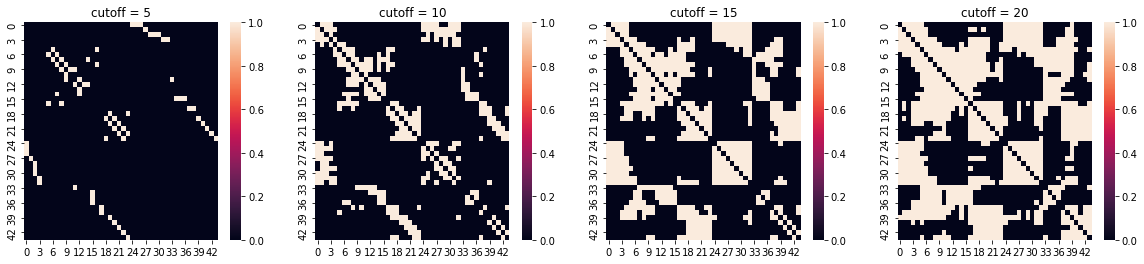

In [444]:
# import seaborn as sns

# multiplier = 5
# fig, ax = plt.subplots(1, 4, figsize=(20, 4))
# for i in range(4):
#     link_cutoff = multiplier * (i+1)
    
#     c_matrix = np.linalg.norm((np.expand_dims(positions, 1) - np.expand_dims(positions, 0)), axis=2) < link_cutoff
#     np.fill_diagonal(c_matrix, False)
    
#     sns.heatmap(c_matrix, ax=ax[i])
#     ax[i].set_title(f'cutoff = {link_cutoff}')
# plt.show()

In [5]:
def get_data(row, unique_symbols):
    n_atoms = row.natoms  
    numbers = row.numbers 
    positions = row.positions
    energy_array = row.data.get('energy')
    energy = torch.from_numpy(energy_array.astype(np.float32)) if energy_array else None

    symbols = row.symbols
    one_hot_symbols = one_hot_encode(symbols, unique_symbols)

    x = np.concatenate((positions, one_hot_encode(symbols, unique_symbols)), axis=1)
    data = tgd.Data(x=x, edge_index=get_edge_index(positions), num_nodes=n_atoms, y=energy)     

    x = torch.from_numpy(
        np.concatenate(
            (positions.astype(np.float32), one_hot_symbols), 
            dtype=np.float32, axis=1
        )
    )

    data = tgd.Data(x=x, edge_index=get_edge_index(positions), num_nodes=n_atoms, y=energy)
    
    return data

In [6]:
# class KaggleDataset(tgd.Dataset):
#     def __init__(self, root, competition_name, transform=None, pre_transform=None, pre_filter=None):
#         self.competition_name = competition_name
#         self.kaggle_api = KaggleApi()
#         self.kaggle_api.authenticate()

#         super().__init__(root, transform, pre_transform, pre_filter)
        
        
#     @property
#     def raw_file_names(self):
#         return [str(f) for f in self.kaggle_api.competition_list_files(self.competition_name)]


#     def kaggle_download(self):
#         self.kaggle_api.competition_download_files(self.competition_name)

#         archive_path = os.path.join(self.root, self.competition_name + '.zip')
#         tgd.extract_zip(archive_path, self.raw_dir, log=False)
#         os.remove(archive_path)

        
# class MOSESDataset(KaggleDataset):
#     def __init__(self, root, competition_name, mode,
#                  transform=None, pre_transform=None, pre_filter=None):
        
#         self.modes = ['train', 'test']
#         if mode not in self.modes:
#             raise ValueError(f'{mode} mode not in {self.modes}')
#         self.mode = mode
#         super().__init__(root, competition_name, transform, pre_transform, pre_filter)
        
#         self.len_ = len(self.processed_file_names)
        
#     def download(self):
#         self.kaggle_download()
        
#     @property
#     def processed_file_names(self):
# #         return [f'{self.mode}_dataset.hdf']

#         database_path = os.path.join(self.raw_dir, f'{self.mode}.db')
#         database = connect(database_path)
#         file_names = [self._saved_file_name(idx) for idx in range(database.count())]
        
#         return file_names
    
#     def process(self):
#         database_path = os.path.join(self.raw_dir, f'{self.mode}.db')  # Путь к файлу базы данных
#         database = connect(database_path)  # Загрузка базы данных
        
# #         attributes = ['id', 'natoms', 'numbers', 'symbols', 'positions', 'mass', 'formula']
# #         data_columns = ['energy']
# #         columns = attributes + data_columns
# #         df = pd.DataFrame(columns=columns)
# #         i = 0
# #         for row in tqdm(database.select(), total=database.count()):
# #             attributes_dict = {col:row.get(col) for col in attributes}
# #             data_columns_dict = {col:row.data.get(col) for col in data_columns}
# #             columns_dict = dict(attributes_dict, **data_columns_dict)
# #             df = df.append(columns_dict, ignore_index=True)

# #             i += 1
# #             if i>1000:
# #                 break
# #         df.to_hdf(os.path.join(self.processed_dir, f'{self.mode}_dataset.hdf'), key='df')
        
#         unique_symbols_path = os.path.join(self.processed_dir, 'unique_symbols.json')
#         if os.path.exists(unique_symbols_path):
#             with open(unique_symbols_path, 'r') as f:
#                 unique_symbols = json.load(f)
#         else:
#             unique_symbols = set()
#             for row in tqdm(database.select(), total=database.count()):
#                 unique_symbols.update(np.unique(row.symbols))
#             unique_symbols = list(unique_symbols)
            
#             with open('test.json', 'w') as f:
#                 json.dump(unique_symbols, f)
                
#         self.unique_symbols = unique_symbols
        
#         for idx, row in tqdm(enumerate(database.select()), total=database.count()):
#             n_atoms = row.natoms  # Количество атомов в молекуле
#             numbers = row.numbers  # Атомные числа атомов молекулы
#             symbols = row.symbols  # Названия атомов молекулы
#             positions = row.positions  # Координаты атомов. np.array размера n_atoms x 3
            
#             if self.mode == 'train':
#                 energy = row.data.get('energy') # Энергия. np.array размера 1, содержащий энергию
            
#             x = np.concatenate((positions, one_hot_encode(symbols, unique_symbols)), axis=1)
#             data = tgd.Data(x=x, edge_index=get_edge_index(positions), num_nodes=n_atoms, y=energy)
            
#             if self.pre_filter is not None and not self.pre_filter(data):
#                 continue

#             if self.pre_transform is not None:
#                 data = self.pre_transform(data)
                
#             torch.save(data, os.path.join(self.processed_dir, self._saved_file_name(idx)))
            
        
#     def len(self):
#         return self.len_

#     def _saved_file_name(self, idx):
#         return f'data_{self.mode}_{idx}.pt'

#     def get(self, idx):
#         data = torch.load(os.path.join(self.processed_dir, self._saved_file_name(idx)))
#         return data   
    
    
# class MOSESDataset(KaggleDataset):
#     def __init__(self, root, competition_name, mode,
#                  transform=None, pre_transform=None, pre_filter=None):
        
#         self.unique_symbols_name = 'unique_symbols.json'
#         super().__init__(root, competition_name, transform, pre_transform, pre_filter)
#         self.unique_symbols_path = os.path.join(self.processed_dir, self.unique_symbols_name)
        
#         self.modes = ['train', 'test']
#         if mode not in self.modes:
#             raise ValueError(f'{mode} mode not in {self.modes}')
#         self.mode = mode
        
#         database_path = os.path.join(self.raw_dir, f'{self.mode}.db')  # Путь к файлу базы данных
#         self.database = ase.db.connect(database_path)  # Загрузка базы данных
#         self.len_ = self.database.count()
        
#         if os.path.exists(self.unique_symbols_path):
#             with open(self.unique_symbols_path, 'r') as f:
#                 self.unique_symbols = json.load(f)
        
        
#     def download(self):
#         self.kaggle_download()
        
#     @property
#     def processed_file_names(self):
#         return [self.unique_symbols_name]
    
#     def process(self):
#         unique_symbols = set()
#         for row in tqdm(self.database.select(), total=self.database.count()):
#             unique_symbols.update(np.unique(row.symbols))
#         unique_symbols = list(unique_symbols)

#         with open(self.unique_symbols_path, 'w') as f:
#             json.dump(unique_symbols, f)
                
#         self.unique_symbols = unique_symbols

        
#     def len(self):
#         return self.len_

#     def _saved_file_name(self, idx):
#         return f'data_{self.mode}_{idx}.pt'

#     def get(self, idx):
#         row = self.database.get(idx+1)
#         n_atoms = row.natoms  # Количество атомов в молекуле
#         numbers = row.numbers  # Атомные числа атомов молекулы
#         symbols = row.symbols  # Названия атомов молекулы
#         positions = row.positions  # Координаты атомов. np.array размера n_atoms x 3

#         if self.mode == 'train':
#             energy = row.data.get('energy')[0] # Энергия. np.array размера 1, содержащий энергию
#         else:
#             energy = None

#         x = torch.from_numpy(np.concatenate((positions.astype(np.float32), one_hot_encode(symbols, self.unique_symbols)), dtype=np.float32, axis=1))
#         data = tgd.Data(x=x, edge_index=get_edge_index(positions), num_nodes=n_atoms, y=energy)

#         if self.pre_filter is not None and not self.pre_filter(data):
#             pass

#         if self.pre_transform is not None:
#             data = self.pre_transform(data)
        
#         return data   
    
    
class MOSESDataset(tgd.InMemoryDataset):
    def __init__(self, competition_name, root, mode, transform=None, pre_transform=None, pre_filter=None):
        self.competition_name = competition_name
        
        self.load_idx = {'train':0, 'val':1, 'test':2}
        self.modes = list(self.load_idx.keys())

        if mode not in self.modes:
            raise ValueError(f'{mode} mode not in {self.modes}')
        self.mode = mode
        
        self.kaggle_api = KaggleApi()
        self.kaggle_api.authenticate()
        
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[self.load_idx[self.mode]])
        

    @property
    def raw_file_names(self):
        return [str(f) for f in self.kaggle_api.competition_list_files(self.competition_name)]

    @property
    def processed_file_names(self):
        modes_data = [f'{mode}_data.pt' for mode in self.modes]
        return modes_data + ['unique_symbols.json']

    def download(self):
        self.kaggle_api.competition_download_files(self.competition_name, path=self.root)

        archive_path = os.path.join(self.root, self.competition_name + '.zip')
        tgd.extract_zip(archive_path, self.raw_dir, log=False)
        os.remove(archive_path)

    def process(self):
        train_val_database_path = os.path.join(self.raw_dir, f'train.db')
        test_database_path = os.path.join(self.raw_dir, f'test.db')
        unique_symbols_name = 'unique_symbols.json'
       
        train_val_database = connect(train_val_database_path)
        train_val_size = train_val_database.count()
        
        test_database = connect(test_database_path)
        test_size = test_database.count()

        unique_symbols_path = os.path.join(self.processed_dir, unique_symbols_name)
        if os.path.exists(unique_symbols_path):
            with open(unique_symbols_path, 'r') as f:
                unique_symbols = json.load(f)
        else:
            unique_symbols = set()
            for row in tqdm(train_val_database.select(), total=train_val_database.count()):
                unique_symbols.update(np.unique(row.symbols))
            unique_symbols = list(unique_symbols)

            with open(unique_symbols_path, 'w') as f:
                json.dump(unique_symbols, f)

        # train/val split
        val_size = 0.2
        val_idxs = np.random.choice(np.arange(train_val_size), size=int(val_size*train_val_size))
        
        mode_list = {
            'train': [],
            'val': [],
            'test': []
        }

        for idx, row in tqdm(enumerate(train_val_database.select()), total=train_val_size):
            data = get_data(row, unique_symbols)
            
            if idx in val_idxs:
                mode_list['val'].append(data)
            else:
                mode_list['train'].append(data)
                
        for idx, row in tqdm(enumerate(test_database.select()), total=test_size):
            data = get_data(row, unique_symbols)
            mode_list['test'].append(data)
           
        
        for mode in self.modes:
            if self.pre_filter is not None:
                mode_list[mode] = [data for data in mode_list[mode] if self.pre_filter(data)]

            if self.pre_transform is not None:
                mode_list[mode] = [self.pre_transform(data) for data in mode_list[mode]]
                
            data, slices = self.collate(mode_list[mode])
            torch.save((data, slices), self.processed_paths[self.load_idx[mode]])
            

In [7]:
competition_name = 'molecular-energy-estimation-rucode'
train_dataset = MOSESDataset(competition_name, '.', 'train')
val_dataset = MOSESDataset(competition_name, '.', 'val')
test_dataset = MOSESDataset(competition_name, '.', 'test')

Processing...


  0%|          | 0/138365 [00:00<?, ?it/s]

  0%|          | 0/70905 [00:00<?, ?it/s]

Done!


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
class GCN(nn.Module):
    def __init__(self, num_node_features, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return global_mean_pool(x, data.batch)

class SimpleGCNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(SimpleGCNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm(hidden_channels, )
        self.lin = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch_index):

        # Step 1. Graph Convolutions

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.bn3(x)

        # Step 2. Global Pooling

        x = global_mean_pool(x, batch_index)

        # Step 3. Classification
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleGCNet(in_channels=train_dataset.num_node_features,
                    hidden_channels=64,
                    out_channels=1).to(device)


model = GCN(train_dataset.num_node_features, 1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.L1Loss()

In [26]:
data = next(iter(train_loader))

In [30]:
criterion(model(data), data.y)

tensor(1409.0341, grad_fn=<L1LossBackward0>)

In [33]:
def train():
    model.train()

    epoch_loss = 0
    for data in tqdm(train_loader):  
        data.to(device)
        out = model(data)  
        loss = criterion(out, data.y.reshape(-1, 1))
        loss.backward()
        epoch_loss += loss  
        optimizer.step() 
        optimizer.zero_grad()

    return epoch_loss 

def validate(loader):
    model.eval()

    loss = 0
    with torch.no_grad():
        for data in tqdm(loader):
            data.to(device)
            out = model(data)  
            loss += criterion(out, data.y.reshape(-1, 1))
        return loss / len(loader) 

In [34]:
train_losses = []
val_losses = []
epochs = 400
for epoch in range(1, epochs+1):
    train_loss = train()
    val_loss = validate(val_loader)
    if epoch % 10 == 0:
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')

  0%|          | 0/3540 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [36]:
database

NameError: name 'database' is not defined